# Activity 0: Fix your code with AI

In [ ]:
m = 2
c = 1 # You need to define c
for x in range(10):
  y = x * m + c
  print(y) # To see the output

1
3
5
7
9
11
13
15
17
19


# Activity 1: Connect your Google Drive
### In this activity we will mount your GDrive in colab, create a new folder to store data, and save some data in the new folder.

**Note:** Don't execute this heading if running on your local environment -> Jupyter lab or jupyter Notebook

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# # Create a folder in the root directory
# !mkdir -p "/content/drive/My Drive/results_ws"

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Module_6_3

/content/drive/MyDrive/Module_6_3


In [ ]:
# Check the current working foder
import os
os.getcwd()

'/content/drive/MyDrive/Module_6_3'

In [ ]:
# Create an "Hello world!" txt and store it in the new folder
with open('hello.txt', 'w') as f:
  f.write('Hello world!')

# Activity 2: Install Conda and CC3D in Colab

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install_miniforge()


⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Miniforge3-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()



✨🍰✨ Everything looks OK!


In [ ]:
# !conda install mamba --quiet # Mamaba is a faster replacement for Conda (it speeds-up pckage resolution and install)

Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mamba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    archspec-0.2.3             |     pyhd8ed1ab_0          48 KB  conda-forge
    ca-certificates-2024.7.4   |       hbcca054_0         151 KB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-24.7.1               |  py310hff52083_0         940 KB  conda-forge
    fmt-10.2.1                 |       h00ab1b0_0         189 KB  conda-forge
    frozendict-2.4.4           |  py310hc51659f_0          48 KB  conda-forge
    libcurl-8.8.0              |       hca28451_0         396 KB  conda-forge
    libmamba-1.5.8             |       had39da4_0         1.6 MB  conda-forge
    libmambapy-1.5.8           |  py310h39ff949_0   

**Note:** We are not creating a new Conda environment when working in Colab. Our installations will only last for the current session and will need to be re-installed upon a new connection.

In [2]:
!mamba install -c conda-forge -c compucell3d compucell3d=4.6.0 --quiet # Install CC3D

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 

done


In [3]:
!mamba install -c conda-forge scikit-image --quiet # A for image manipulation and analysis

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [5]:
!mamba install -c conda-forge pandas --quiet # A package to handle, manipulate, and analyse dataframes

In [6]:
!mamba install -c conda-forge multiprocess --quiet # A package to handle multiprocessing (parallel execution of multiple jobs)

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


# Activity 3: Prepare to run parameter searches programmatically

## Import dependencies

In [7]:
import numpy as np
from time import time # Useful to track execution time
import os # Work with system folders and files

from cc3d.CompuCellSetup.CC3DCaller import CC3DSimService # Needed to instantiate simulations

# Import plugins to be used in the simulation
from cc3d.core.PyCoreSpecs import (PottsCore,
                                   Metadata,
                                   CellTypePlugin,
                                   VolumePlugin,
                                   CenterOfMassPlugin,
                                   NeighborTrackerPlugin,
                                   PixelTrackerPlugin,
                                   ContactPlugin,
                                   ChemotaxisPlugin,
                                   ChemotaxisParameters,
                                   ChemotaxisTypeParameters,
                                   DiffusionSolverFE,
                                   UniformInitializer)

# Import widgets to visualize simulations in Jupyter Notebooks
from IPython.display import display
from cc3d.core.GraphicsUtils.JupyterGraphicsFrameWidget import CC3DJupyterGraphicsFrameGrid as cc3djgf
import ipywidgets

# !!!!!!!!!!!!
# from VM_steppable import analysisSteppable
# !!!!!!!!!!!!

from tqdm import tqdm
from multiprocess import Process, Queue # Needed for multiprocessing


## Create a steppable to perform data analysis

In [8]:
from cc3d.core.PySteppables import *

import scipy.ndimage as ndimage
import skimage.measure as measure
from skimage.morphology import medial_axis

class analysisSteppable(SteppableBasePy):

    def __init__(self, input_dict, frequency=100):

        SteppableBasePy.__init__(self,frequency)
        self.input_dict = input_dict

    def step(self, mcs):
        pass

    def finish(self):
        i_img = np.ones((200, 200), dtype=np.uint8)
        img = np.zeros((200, 200), dtype=np.uint8)

        for x, y, z in self.every_pixel():

            cell = self.cell_field[x, y, z]
            if cell:
                img[x,y] = 1
                i_img[x,y] = 0
            else:
                img[x,y] = 0
                i_img[x,y] = 1

        # Measure the lacunae
        labeled_image, num_labels = ndimage.label(i_img)
        regions = measure.regionprops(labeled_image)
        regions = sorted(regions, key=lambda x: x.area, reverse=True)
        area_list = []
        for i, region in enumerate(regions, start=1):
            # Exclude regions touching the border of the image
            if region.bbox[0] == 0 or region.bbox[1] == 0 or region.bbox[2] == 399 or region.bbox[3] == 399:
                continue
            # Get the coordinates of the centroid of the region
            y, x = region.centroid

            # Filter out non-informative results
            if region.area > 10 and region.area < 10000:
                area_list.append(region.area)
        area_arr = np.array(area_list)

        # Measure the network
        skel, distance =  medial_axis(img, return_distance=True)
        dist_on_skel = distance * skel
        sort_px_list = np.sort(dist_on_skel.ravel())
        nonzero_pixels = sort_px_list[sort_px_list > 0]
        nonzero_pixels = nonzero_pixels[::-1]
        pix_array = np.array(nonzero_pixels)

        n_regions = area_arr.shape[0]
        mean_l_area = np.mean(area_arr) if n_regions > 0 else 0
        std_l_area = np.std(area_arr) if n_regions > 0 else 0

        return_obj = {**self.input_dict, "n_regions": n_regions,
                        "mean_l_area": mean_l_area, "std_l_area": std_l_area,
                        "len_network": pix_array.shape[0], "mean_n_width": np.mean(pix_array),
                        "std_n_width": np.std(pix_array)}
        CompuCellSetup.persistent_globals.return_object = return_obj

## Create a class to handle simulation initialisation and running

In [9]:
class AngioSim:
    """
    Class to run the Angiogenesis simulation as individual instances or in batch mode

    Methods:
    ___________
    __init__(self, me_ce:float=4.0, ee_ce:float=1.0, l_chemo:int=500, lin_sat_cf:float=0.1, ve_dir:float=1.0, ve_der:float=0.3, ve_sec:float=0.3, visualisation:bool=False) -> None
        Build the simulation with the a set of default parameters

    run(self, steps:int=1000) -> None
        Run the simulation for the given number of steps

    store_snapshot(self) -> None
        Store a snapshot of the simulation

    """
    def __init__(self,
                 me_ce:float=4.0,
                 ee_ce:float=1.0,
                 l_chemo:int=500,
                 lin_sat_cf:float=0.1,
                 ve_dir:float=1.0,
                 ve_der:float=0.3,
                 ve_sec:float=0.3,
                 visualisation:bool=False,
                 save_snapshot:bool=False) -> None:
        """
        Build the simulation with the given parameters

        Parameters:
        ___________
        me_ce: float
            Contact energy between the medium and the endothelial cells
        ee_ce: float
            Contact energy between the endothelial cells
        l_chemo: int
            Chemotaxis lambda parameter
        lin_sat_cf: float
            Linear saturation coefficient of the VEGF field
        ve_dir: float
            Global VEGF diffusion rate
        ve_der: float
            Global VEGF decay rate
        ve_sec: float
            VEGF secretion rate by the endothelial cells
        visualisation: bool
            Whether to visualise the simulation
        """

        self.save_snap = save_snapshot
        self.params = {"me_ce": me_ce,
                       "ee_ce": ee_ce,
                       "l_chemo": l_chemo,
                       "lin_sat_cf": lin_sat_cf,
                       "ve_dir": ve_dir,
                       "ve_der": ve_der,
                       "ve_sec": ve_sec}
        # initialise the specs list
        self.specs = []
        self.working_dir = os.getcwd()
        self.output_dir = os.path.join(self.working_dir, "output")

        # https://compucell3dreferencemanual.readthedocs.io/en/latest/cc3d_python.html

        # Define the Potts Core Specs
        simCore = PottsCore(dim_x=200,
                            dim_y=200,
                            dim_z=1,
                            steps=10000,
                            fluctuation_amplitude=5.0,
                            neighbor_order=1,
                            boundary_x="Periodic",
                            boundary_y="Periodic")

        # Define the Metadata Specs
        simMeta = Metadata(num_processors=1)

        # Append the specs to the list
        self.specs.append(simCore)
        self.specs.append(simMeta)

        # Define the Cell Types in the simulation
        simCelltypes = CellTypePlugin("Medium", "EC")
        self.specs.append(simCelltypes)

        # Define the Volume Energy Specifcations
        simVolume = VolumePlugin()
        simVolume.param_new("EC", 50.0, 5.0) # Volume, target volume, lambda volume
        self.specs.append(simVolume)

        simCOM = CenterOfMassPlugin()
        self.specs.append(simCOM)

        simNtrack = NeighborTrackerPlugin()
        self.specs.append(simNtrack)

        simPXtrack = PixelTrackerPlugin()
        self.specs.append(simPXtrack)

        # Define the Contact Energy Specifications
        simContact = ContactPlugin(neighbor_order=4)
        simContact.param_new("Medium", "EC", me_ce) # Medium, EC, contact energy
        simContact.param_new("EC", "EC", ee_ce) # EC, EC, contact energy
        self.specs.append(simContact)

        # Define the Diffusion Solver Specifications
        simDiffusion = DiffusionSolverFE()

        # Define a new field for VEGF
        vegf = simDiffusion.field_new("VEGF")

        # Set the boundary conditions for the VEGF field (all periodic)
        bds = [('x', 'min'), ('x', 'max'), ('y', 'min'), ('y', 'max')]
        for bd in bds:
            setattr(vegf.bcs, f"{bd[0]}_{bd[1]}_type", 'Periodic')

        # Set the global diffusion and decay parameters for the VEGF field
        vegf.diff_data.diff_global = ve_dir
        vegf.diff_data.decay_global = ve_der
        # Set the decay parameters for the EC cells
        vegf.diff_data.decay_types["EC"] = 0.0
        # Set the secretion parameters for the EC cells
        vegf.secretion_data_new("EC", ve_sec)
        self.specs.append(simDiffusion)

        # Define the Chemotaxis specifications
        f = ChemotaxisParameters(field_name="VEGF", solver_name="DiffusionSolverFE")
        kwargs = {"lambda_chemo": l_chemo, "towards": "Medium", "linear_sat_cf": lin_sat_cf}
        p = ChemotaxisTypeParameters("EC", **kwargs)
        f.params_append(p)
        simChemotx = ChemotaxisPlugin(f)
        self.specs.append(simChemotx)

        # Define the initial layout of cells in the simulation
        simInit = UniformInitializer()
        simInit.region_new(pt_min=[1,1,0], pt_max=[199,199,1], width=7, gap=3, cell_types=['EC'])
        self.specs.append(simInit)

        # Instantiate the simulation service
        self.cc3d_sim = CC3DSimService(output_dir=self.output_dir)
        # Register the specs in the simulation service
        self.cc3d_sim.register_specs(self.specs)

        #!!!!!!!!!!
        # Register steppables in the simulation service
        self.cc3d_sim.register_steppable(analysisSteppable(input_dict=self.params), frequency=100)
        #!!!!!!!!!!

        # Run the simulation
        self.cc3d_sim.run()
        self.cc3d_sim.init()
        self.cc3d_sim.start()
        if visualisation:
            self.frame = self.cc3d_sim.visualize()
            self.frame.field_name = "VEGF"
            self.frame.max_range = 3.0

    def run(self, steps:int=1000) -> None:
        """
        Run the simulation for the given number of steps

        Parameters:
        ___________
        steps: int
            Number of steps to run the simulation for
        """
        for n in tqdm(range(0, steps)): # Note the use of tqdm to track progress
            self.cc3d_sim.step()
        if self.save_snap:
            self.store_snapshot()
        self.cc3d_sim.finish()

    def store_snapshot(self) -> None:
        """
        Store the current snapshot of the simulation
        """
        # Create a string with the values of the parameters separated by underscores
        values_str = "_".join(map(str, self.params.values()))
        name = f'snap_{values_str}'
        self.cc3d_sim.store_lattice_snapshot(output_dir_name=self.output_dir,output_file_core_name=name)



## Create a class to handle paramter searches and run the Angio Sim

In [10]:
class AngioSimBatch:
    """
    Class to perform parameter sweeps in the Angiogenesis simulation
    and run multiple instances serially or in parallel
    """
    def __init__(self, default_values:dict, p_ranges:np.ndarray ,steps:int, n_cpus:int=10) -> None:
        self.default_values = np.array(list(default_values.values()))
        self.param_names = list(default_values.keys())
        self.p_ranges = p_ranges
        self.steps = steps
        self.n_cpus = n_cpus

    def instance_exec(self, input_vector:np.ndarray, queue:bool=False) -> None:
        instance = AngioSim(me_ce=input_vector[0],
                            ee_ce=input_vector[1],
                            l_chemo=input_vector[2],
                            lin_sat_cf=input_vector[3],
                            ve_dir=input_vector[4],
                            ve_der=input_vector[5],
                            ve_sec=input_vector[6])
        instance.run(steps=self.steps)
        if queue:
            queue.put(instance.cc3d_sim.sim_output)
        else:
            return instance.cc3d_sim.sim_output

    def run_batch_serial(self, samples:np.ndarray) -> None:
        results = []
        for sample in samples:
            results.append(self.instance_exec(sample))

        return results

    def one_at_a_time_sample(self, param2sample:list[str], n:int=10) -> np.array:
        # impose the minimum number of samples to be 2 (no big deal sampling 1 point right?)
        n = n if n > 1 else 2

        all_samples = []
        for param in param2sample:
            # Generate an n dimensional array filled with default values
            samples = np.array([self.default_values for i in range(n)])
            idx = self.param_names.index(param)
            # Generate samples for the parameter
            sample = np.linspace(self.p_ranges[idx][0], self.p_ranges[idx][1], n)
            # Update the samples array with the new values (i.e., change the column corresponding to the parameter)
            samples[:,idx] = sample
            all_samples.append(samples)

        return np.vstack(all_samples)

    def lhs_sampling(self, n_samples, params2sample:list[str]):
        # Create an array filled with default values to hold the samples
        result = np.array([self.default_values for i in range(n_samples)])

        for param in params2sample:

            # Get the index of the parameter in the list of parameters
            idx = self.param_names.index(param)

            # Generate the intervals for the parameter from the parameter ranges
            samples = np.linspace(self.p_ranges[idx][0], self.p_ranges[idx][1], n_samples)

            # Shuffle the samples
            np.random.shuffle(samples)

            # Update the samples array with the new values (i.e., change the column corresponding to the parameter)
            result[:,idx] = samples

        return result

# Activity 4: Run one-at-a-time, and lhs parameter scans

In [ ]:
default_values = {'me_ce': 4.0,
                  'ee_ce': 1.0,
                  'l_chemo': 500,
                  'lin_sat_cf': 0.1,
                  've_dir': 1.0,
                  've_der': 0.3,
                  've_sec': 0.3}

p_ranges = np.array([[1.0, 5.0],
                     [1.0, 40.0],
                     [10, 1000],
                     [0, 0.5],
                     [1, 10],
                     [0.1, 0.5],
                     [0.05, 0.5]])

# Create an instance of the AngioSimBatch class
batch = AngioSimBatch(default_values=default_values, p_ranges=p_ranges, steps=100)

# cases = batch.one_at_a_time_sample(param2sample=['l_chemo'], n=5)
cases = batch.lhs_sampling(n_samples=10, params2sample=['l_chemo','ve_der'])

# Run a batch of simulation using the cases sampled above
results = batch.run_batch_serial(cases)
for result in results:
    print(f'regions: {result["n_regions"]}')


WILL RUN SIMULATION FROM BEGINNING


100%|██████████| 100/100 [00:04<00:00, 23.61it/s]


WILL RUN SIMULATION FROM BEGINNING


100%|██████████| 100/100 [00:02<00:00, 35.64it/s]


WILL RUN SIMULATION FROM BEGINNING


100%|██████████| 100/100 [00:02<00:00, 37.38it/s]


WILL RUN SIMULATION FROM BEGINNING


100%|██████████| 100/100 [00:03<00:00, 31.97it/s]


WILL RUN SIMULATION FROM BEGINNING


100%|██████████| 100/100 [00:05<00:00, 19.71it/s]


WILL RUN SIMULATION FROM BEGINNING


100%|██████████| 100/100 [00:03<00:00, 33.10it/s]


WILL RUN SIMULATION FROM BEGINNING


100%|██████████| 100/100 [00:02<00:00, 38.05it/s]


WILL RUN SIMULATION FROM BEGINNING


100%|██████████| 100/100 [00:03<00:00, 32.10it/s]


WILL RUN SIMULATION FROM BEGINNING


 22%|██▏       | 22/100 [00:00<00:03, 23.49it/s]

# Activity 5: Analyse data

In [ ]:
# We will use the pandas library for data wrangling (# Pandas: https://pandas.pydata.org/)
import pandas as pd

In [ ]:
# Turn the results list into a fancy pandas DataFrame
df = pd.DataFrame(results)
df

,me_ce,ee_ce,l_chemo,lin_sat_cf,ve_dir,ve_der,ve_sec,n_regions,mean_l_area,std_l_area,len_network,mean_n_width,std_n_width
0,4.0,1.0,230.0,0.1,1.0,0.277778,0.3,22,418.272727,355.009114,3773,2.557026,1.033328
1,4.0,1.0,890.0,0.1,1.0,0.322222,0.3,62,398.500000,708.006806,4286,1.484051,0.527029
2,4.0,1.0,780.0,0.1,1.0,0.500000,0.3,90,264.311111,240.632437,4881,1.447845,0.503051
3,4.0,1.0,1000.0,0.1,1.0,0.233333,0.3,43,422.348837,519.256082,4011,1.463850,0.500810
4,4.0,1.0,560.0,0.1,1.0,0.144444,0.3,33,630.909091,730.999373,3751,2.100864,0.918786
5,4.0,1.0,450.0,0.1,1.0,0.188889,0.3,45,493.222222,533.598888,3866,2.126127,0.842186
6,4.0,1.0,670.0,0.1,1.0,0.100000,0.3,30,624.766667,693.411359,3539,2.027503,0.784310
7,4.0,1.0,340.0,0.1,1.0,0.366667,0.3,57,361.017544,364.459681,4284,2.106562,0.812242
8,4.0,1.0,10.0,0.1,1.0,0.411111,0.3,0,0.000000,0.000000,1862,4.739978,2.242390
9,4.0,1.0,120.0,0.1,1.0,0.455556,0.3,2,155.000000,119.000000,3355,3.022778,1.318756


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['l_chemo'].plot(kind='hist', bins=20, title='l_chemo')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['ve_der'].plot(kind='hist', bins=20, title='ve_der')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['n_regions'].plot(kind='hist', bins=20, title='n_regions')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='l_chemo', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='l_chemo', y='ve_der', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='ve_der', y='n_regions', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='n_regions', y='mean_l_area', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['l_chemo']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('l_chemo')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['ve_der']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('ve_der')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['n_regions']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('n_regions')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['mean_l_area']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('mean_l_area')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['l_chemo'].plot(kind='line', figsize=(8, 4), title='l_chemo')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['ve_der'].plot(kind='line', figsize=(8, 4), title='ve_der')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['n_regions'].plot(kind='line', figsize=(8, 4), title='n_regions')
plt.gca().spines[['top', 'right']].set_visible(False)

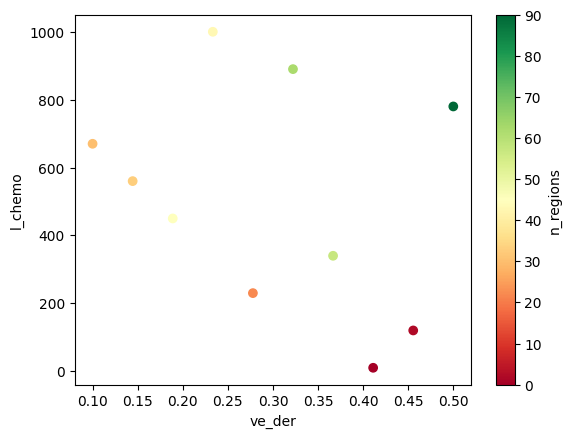

In [ ]:
# Plot ve_der vs l_chemo, marks colur = n_regions use matplotlib
import matplotlib.pyplot as plt

plt.scatter(df['ve_der'], df['l_chemo'], c=df['n_regions'], cmap='RdYlGn')
plt.xlabel('ve_der')
plt.ylabel('l_chemo')

# Add colur scale legend
cbar = plt.colorbar()
cbar.set_label('n_regions')

plt.show()





## More on data manipulation and plotting

In [ ]:
# Load a csv file into a pd.DataFrame
df_lhs = pd.read_csv('/content/drive/MyDrive/m34_ws/results_lhs_ee_sc.csv', index_col=0)

In [ ]:
df_lhs.plot.scatter(x='ee_ce', y='l_chemo', c='mean_n_width', colormap='viridis', s=30, alpha=0.5)

In [ ]:
# Load a csv file into a pd.DataFrame
df_oat = pd.read_csv('/content/drive/MyDrive/m34_ws/results_oat_all_sc.csv', index_col=0)

In [ ]:
filtr_df = df_oat[(df_oat['ee_ce'] != 1)]

filtr_df.plot.scatter(x='ee_ce', y='n_regions', c='mean_n_width', colormap='viridis', s=30, alpha=0.5)

In [ ]:
filtr_df = df_oat[(df_oat['l_chemo'] != 500)]

filtr_df.plot.scatter(x='l_chemo', y='n_regions', c='mean_n_width', colormap='viridis', s=30, alpha=0.5)

# Activity 6: Run parallel in Colab

## Make sure GDrive is mounted to allow saving files locally (as in activity 1)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/results_ws"


In [ ]:
%cd /content/drive/My Drive/results_ws


In [ ]:
!python /content/drive/MyDrive/Module_6_3/AngioSim_DataWrangling_PS.py

Detected CC3D_OPENCL_SOLVERS_DIR: /usr/local/lib/python3.10/site-packages/cc3d/cpp/CompuCell3DSteppables/OpenCL/
/usr/local/lib/python3.10/site-packages/cc3d/core/Configuration/SettingUtils.py:248: UserWarning: Setting not set: PlayerSizes
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
/usr/local/lib/python3.10/site-packages/cc3d/core/Configuration/SettingUtils.py:248: UserWarning: Setting not set: PlayerSizesFloating
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
/usr/local/lib/python3.10/site-packages/cc3d/core/Configuration/SettingUtils.py:248: UserWarning: Setting not set: RecentSimulations
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
running batch 0 to 4
Random number generator: MersenneTwister
Random number generator: MersenneTwister
WILL RUN SIMULATION FROM BEGINNING
Random number generator: MersenneTwister
Random number generator: MersenneTwister
WILL RUN SIMULATION FROM BEGINNING
Random number generator: MersenneTwister
WILL RUN SIMULATION FR

In [ ]:
# Import the results from json file

import json

with open('results/res_ws.json', 'r') as f:
    results = json.load(f)

In [ ]:
# turn results into a fancy pandas dataframe

df = pd.DataFrame(results)
# invert colums and rows
df = df.T
df